# 7. 다대일 RNN Modeling Review

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random
from torchtext.data import TabularDataset

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

cpu와 cuda 중 다음 기기로 학습함: cpu


## 7-1. Review Data 수집 및 전처리

In [2]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x28a2c456d08>)

In [2]:
import pandas as pd

df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [3]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


In [4]:
# Sample 수가 많으므로, 연산 분석용으로 대폭 줄여 새로운 파일을 만든 후 사용
df = pd.read_csv('IMDb_Reviews_test.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,It would be unfair to the actors to condemn th...,0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [5]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 20


### 훈련 데이터, 평가 데이터, 테스트 데이터로 분리

In [6]:
train_df = df[:15]
test_df = df[15:]

In [7]:
train_df.to_csv("train_20_data.csv", index=False)
test_df.to_csv("test_20_data.csv", index=False)

## 7-2. Field 정의 및 Dataset 만들기

In [8]:
TEXT = data.Field(sequential=True,lower=True, batch_first=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [9]:
trainset, testset = TabularDataset.splits(
        path='.', train='train_20_data.csv', test='test_20_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)
        # field: Data column format 정의

### Dataset sample 확인

In [10]:
print('훈련 샘플의 개수 : {}'.format(len(trainset)))
print('테스트 샘플의 개수 : {}'.format(len(testset)))

훈련 샘플의 개수 : 15
테스트 샘플의 개수 : 5


In [11]:
print(trainset[0])

In [12]:
# trainset 내용물 확인
print(vars(testset[0]))

{'text': ['in', 'truth', 'though,', "there's", 'a', 'lack', 'of', 'dramatic', 'tension', 'throughout', 'for', 'which', 'the', 'action', 'sequences', "don't", 'fully', 'compensate', 'and', 'you', "don't", 'care', 'a', 'fig', 'for', 'any', 'of', 'the', 'leading', 'characters.', 'one', 'of', 'those', 'films', 'where', 'the', 'actors', 'probably', 'enjoyed', 'making', 'it', 'more', 'than', 'the', 'viewers', 'did', 'watching', 'it.'], 'label': '0'}


## 7-3. Vocabulary set 만들기

In [13]:
TEXT.build_vocab(trainset, min_freq=2)      # 단어 집합 생성, 단어 수가 적으므로 최소 횟수를 2로 설정
LABEL.build_vocab(trainset)

In [14]:
n_vocab = len(TEXT.vocab)
print('단어 집합의 크기 : {}'.format(n_vocab))

단어 집합의 크기 : 60


In [15]:
# 수집된 전체 단어 확인
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001D063E213C8>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'of': 3, 'to': 4, 'and': 5, 'a': 6, 'it': 7, 'i': 8, 'one': 9, 'is': 10, 'this': 11, 'was': 12, 'in': 13, 'that': 14, 'but': 15, 'ever': 16, 'you': 17, 'are': 18, 'for': 19, 'movie': 20, 'be': 21, 'by': 22, 'first': 23, 'had': 24, "it's": 25, 'just': 26, 'make': 27, 'most': 28, 'movies': 29, 'not': 30, 'there': 31, 'they': 32, '/><br': 33, 'best': 34, 'could': 35, 'end': 36, 'far': 37, 'film': 38, 'films': 39, 'get': 40, 'happens': 41, 'have': 42, 'her': 43, 'if': 44, 'like': 45, 'makes': 46, 'many': 47, 'more': 48, 'movie.': 49, 'no,': 50, 'only': 51, 'really': 52, 'recommended.': 53, 'see': 54, 'seen.': 55, 'watch': 56, 'what': 57, 'with': 58, 'worse': 59})


In [16]:
trainset_2, valset = trainset.split(split_ratio=0.75)       # 훈련 데이터와 평가 데이터 분리

In [17]:
print('훈련 샘플의 개수 : {}'.format(len(trainset_2)))
print('평가 샘플의 개수 : {}'.format(len(valset)))

훈련 샘플의 개수 : 11
평가 샘플의 개수 : 4


## 7-4. Data loader

### Dataloader test

In [18]:
BATCH_SIZE = 2

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset_2, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False, sort=False)               
        # shuffle 진행 안하면 Data 변환 추적 쉬움.
        # data.BucketIterator.splits 조건에 sort=False를 하지 않으면
        # " '<' not supported ... " Error 발생

In [19]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치의 개수 : 6
검증 데이터의 미니 배치의 개수 : 2
테스트 데이터의 미니 배치의 개수 : 3


In [20]:
batch = next(iter(train_iter))       # Dataloader가 iterator 역할을 잘하는지 확인.
print(batch)                         # 재실행 때마다 sample 크기 변해야 됨.


[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x53]
	[.label]:[torch.LongTensor of size 2]


In [21]:
batch2 = next(iter(val_iter))
print(batch2)


[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x36]
	[.label]:[torch.LongTensor of size 2]


In [22]:
print('훈련 데이터의 샘플의 개수 재확인 : {}'.format(len(train_iter.dataset)))
print('검증 데이터의 샘플의 개수 재확인 : {}'.format(len(val_iter.dataset)))
print('테스트 데이터의 샘플의 개수 재확인 : {}'.format(len(test_iter.dataset)))

훈련 데이터의 샘플의 개수 재확인 : 11
검증 데이터의 샘플의 개수 재확인 : 4
테스트 데이터의 샘플의 개수 재확인 : 5


### batch Iterator test

In [23]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('b is {}. batch is {}'. format(b, batch))              # batch 개수 확인

b is 0. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x31]
	[.label]:[torch.LongTensor of size 2]
b is 1. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x44]
	[.label]:[torch.LongTensor of size 2]
b is 2. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x25]
	[.label]:[torch.LongTensor of size 2]
b is 3. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x36]
	[.label]:[torch.LongTensor of size 2]
b is 4. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x53]
	[.label]:[torch.LongTensor of size 2]
b is 5. batch is 
[torchtext.data.batch.Batch of size 1]
	[.text]:[torch.LongTensor of size 1x49]
	[.label]:[torch.LongTensor of size 1]


In [24]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('x is {}. y is {}'. format(x, y)) 
    print('수정된 Y 값:' , y.data.sub_(1))    # lable 값 조정: y값에서 () 값을 뺌, sub 대신 add를 하면 더함

x is tensor([[ 0,  7,  0,  0, 11, 12,  0,  9,  0,  2,  0, 20,  8, 24, 16, 55,  0, 14,
          0,  8, 42,  0, 47, 48, 29, 14, 18, 59,  0, 10,  7,  0,  0,  4, 21,  0,
          8, 24,  4,  0, 11, 20,  6,  0,  0,  3,  0, 15,  7, 12,  6,  0,  0],
        [11, 10,  0,  9,  3,  2, 28,  0,  0,  4,  6, 20,  8, 42, 16, 55, 19,  0,
          3,  0,  0,  5,  0, 29, 25,  6,  0, 19,  2,  0,  3, 17, 25,  0, 53,  0,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]). y is tensor([2, 1])
수정된 Y 값: tensor([1, 0])
x is tensor([[ 2,  9,  0, 10,  2,  0,  4,  0, 13,  0,  0,  0,  0,  0,  0,  0,  4,  0,
          0, 13,  2,  0,  0, 11, 26, 46,  2, 38,  6,  0,  0,  0, 15, 44, 17,  0,
         54,  0,  0, 17,  0,  0,  6,  0,  0,  4,  0,  0, 53],
        [ 2, 38,  0,  0, 13,  0,  0,  5,  0, 21, 51,  0, 13, 25,  0,  0,  0, 44,
         17, 56, 14,  0,  0,  0,  0,  0, 33,  0,  0, 33,  0,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]). y is tensor([1

In [25]:
 x            # 현재 x 입력값 확인

tensor([[ 7, 12,  2,  0,  5,  0, 58,  0,  0,  5,  6,  0,  0,  0, 35, 40,  0,  4,
         27,  6, 49,  0,  0,  0,  0,  0,  3, 11,  0,  0, 12,  0,  4, 40,  2,  0,
          0, 10,  9,  3,  2, 28,  0,  0,  0, 16,  0,  6,  0,  4, 27,  6, 49],
        [ 0,  0,  5,  8,  0,  0, 30, 56,  0, 29, 19,  2,  0,  0, 14, 32, 18,  0,
          0, 32,  0,  2,  0,  5, 26, 30,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [26]:
 x.shape  

torch.Size([2, 53])

## 7-5. Reviewing RNN, GRU Model

* Embedding, RNN/GRU, Cost Function 동작 확인

### hyperparameters

In [27]:
n_classes = 2     # 분류되어야 할 결과 수 (긍정 or 부정)
embed_dim= 8      # 임베딩 된 차원의 크기 : RNN 층 입력 차원의 크기가 됨
hidden_size = 6  # RNN의 은닉층 크기

### Embedding Test

In [28]:
# num_embedding는 trainset 단어 전체 갯수인 n_vocab로 지정
Emb_Test=nn.Embedding(num_embeddings=n_vocab,   embedding_dim=embed_dim)

# 가중치 확인
print(Emb_Test.weight.shape)   # (단어갯수, embedding dim)
print(Emb_Test.weight)    

torch.Size([60, 8])
Parameter containing:
tensor([[ 1.8423e+00,  5.1889e-01, -1.7119e+00, -1.7014e+00,  2.0194e+00,
         -2.6861e-01, -1.3072e-01, -1.4374e+00],
        [ 3.9077e-01, -1.8968e-02, -1.3527e+00, -7.3082e-01,  9.8792e-01,
         -4.1941e-01, -5.8490e-01, -7.8233e-01],
        [ 2.7799e+00,  1.2220e+00, -3.3645e-01, -9.6506e-01, -1.2966e-01,
         -6.0177e-01,  1.4500e-01, -1.4983e-01],
        [-4.3740e-01,  7.7923e-01, -5.8339e-02, -2.0305e+00,  1.4829e+00,
          4.9404e-01,  2.4922e-01,  1.7470e+00],
        [-2.6167e-01, -7.3239e-01,  1.6980e+00, -1.7917e-01,  1.9231e+00,
          2.8795e-01,  9.3680e-01, -2.4031e+00],
        [-1.4789e-01,  8.9670e-01,  5.4813e-01, -1.6391e+00, -1.8153e+00,
         -2.0663e-01, -5.2595e-01, -1.6977e+00],
        [ 8.1679e-01,  4.0964e-01,  2.1623e-01,  1.0898e+00,  1.7303e-01,
          1.6677e-01, -1.1372e+00, -8.2083e-01],
        [-1.7927e+00,  8.7719e-01,  2.1641e+00, -1.8553e-01,  9.9064e-01,
          7.4259e-01,  

In [29]:
Emb_Test(x).shape           # 임베딩 결과 차원 확인 : (batch 크기 x 문장 단어 크기 x embedding 크기)

torch.Size([2, 53, 8])

In [30]:
Emb_Test(x).size(0)        # batch size 출력

2

### RNN input Test

In [31]:
rnn_test = nn.RNN(embed_dim, hidden_size, batch_first=True) 

# model에 구성된 파라미터 가중치 확인 : 추가 분석은 아래 참고
print(rnn_test.parameters())
print(next(rnn_test.parameters()).shape)     # 벡터 크기 : (hidden_size, embed_dim)

<generator object Module.parameters at 0x000001D063E25548>
torch.Size([6, 8])


In [32]:
output_rnn, hidden_rnn = rnn_test (Emb_Test(x))      # Tuple 형태의 결과를 분리
print(output_rnn.shape)                # (batch 크기 x 문장 길이 x 은닉층 크기)
print(hidden_rnn.shape)                # (층 크기 x batch 크기 x 은닉층 크기)

torch.Size([2, 53, 6])
torch.Size([1, 2, 6])


### GRU input Test
* 긴 문장에서는 RNN보다 GRU가 더 나은 결과를 보임

In [33]:
gru_test = nn.GRU(embed_dim, hidden_size, batch_first=True)

# model에 구성된 파라미터 가중치 확인 : 추가 분석은 아래 참고
print(gru_test.parameters())                # RNN과 parameter 벡터가 다름
print(next(gru_test.parameters()).shape)    # (hidden_size x3 , embed_dim)

<generator object Module.parameters at 0x000001D063E25D48>
torch.Size([18, 8])


In [34]:
output_gru, hidden_gru = gru_test (Emb_Test(x))      # Tuple 형태의 결과를 분리
print(output_gru.shape)             # 결과와 은닉 가중치 벡터 크기는 RNN과 동일
print(hidden_gru.shape)

torch.Size([2, 53, 6])
torch.Size([1, 2, 6])


In [35]:
output_rnn

tensor([[[-0.5692,  0.5825, -0.6861, -0.2384,  0.1169,  0.4754],
         [ 0.4129,  0.8338, -0.6284,  0.7119,  0.0733,  0.1744],
         [ 0.9365, -0.5986,  0.8250,  0.8036,  0.8741, -0.3218],
         [ 0.9942, -0.8088,  0.7827,  0.4465,  0.8710, -0.1135],
         [ 0.6206,  0.5289,  0.3518,  0.7245,  0.9080, -0.6963],
         [ 0.9959, -0.8320,  0.8869,  0.5873,  0.8435,  0.3685],
         [ 0.0807, -0.0792,  0.4226, -0.8140,  0.0791, -0.1991],
         [ 0.9876, -0.7124,  0.4210,  0.8327,  0.5429,  0.6553],
         [ 0.9958, -0.5658,  0.5685,  0.2875,  0.8314, -0.3111],
         [ 0.6142,  0.5468,  0.4286,  0.7706,  0.9084, -0.5523],
         [ 0.6119, -0.7902,  0.9009, -0.6016,  0.3985,  0.3108],
         [ 0.9865, -0.6085,  0.2863,  0.6835,  0.6127,  0.1683],
         [ 0.9955, -0.6410,  0.6886,  0.4448,  0.8511, -0.0617],
         [ 0.9938, -0.7132,  0.7163,  0.4934,  0.8325, -0.0740],
         [ 0.4445, -0.3917,  0.9262, -0.7782,  0.6859, -0.3345],
         [-0.4005, -0.933

### Return Analysis

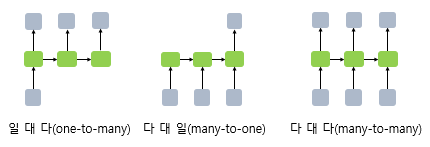

* 리뷰 감성 분류는 긍정/부정 하나의 분류이므로, RNN 다대일 구조이며, 이 경우 RNN 연산 결과는 n개 은닉 상태 중에서 마지막 번째만 선택

In [36]:
x_out = output_rnn[:, -1, :]
print(x_out)

tensor([[-0.8647,  0.6855, -0.3529, -0.2938,  0.1734,  0.1462],
        [ 0.9493,  0.3112,  0.0887, -0.0429,  0.1871,  0.6228]],
       grad_fn=<SliceBackward>)


### dropout

In [37]:
dropout_p=0.3         # '0'은 dropout이 없고, '1'이면 모두 zero로 만듬
dropout = nn.Dropout(dropout_p)
x_out = dropout(x_out)
print(x_out)

tensor([[-1.2353,  0.0000, -0.5042, -0.0000,  0.2478,  0.2089],
        [ 1.3562,  0.4446,  0.0000, -0.0612,  0.2673,  0.0000]],
       grad_fn=<MulBackward0>)


### Linear Regression test for Binary Selection

In [38]:
linear_test = nn.Linear(hidden_size, n_classes)
out=linear_test(x_out)
out                          # (batch 크기 x 분류 갯수)

tensor([[-0.4373, -0.2018],
        [-0.1927,  0.7488]], grad_fn=<AddmmBackward>)

In [39]:
# 가중치 확인
print(linear_test.weight.shape)
linear_test.weight

torch.Size([2, 6])


Parameter containing:
tensor([[ 0.2510, -0.3586, -0.3861, -0.3712, -0.3518,  0.3240],
        [ 0.3765, -0.2576,  0.1041, -0.2520,  0.0994, -0.0942]],
       requires_grad=True)

### Comparing selection results with labels

In [40]:
# 0과 1에서 높은 확률값 선택
print(out.max(1))
print("결과값 : ", out.max(1)[1])

torch.return_types.max(
values=tensor([-0.2018,  0.7488], grad_fn=<MaxBackward0>),
indices=tensor([1, 1]))
결과값 :  tensor([1, 1])


In [41]:
y     # 현재 Label값들

tensor([1, 0])

In [42]:
# out값을 y차원에 맞춰 다시 정렬
out.max(1)[1].view(y.size())

tensor([1, 1])

In [43]:
# out값과 Label이 맞는 갯수
(out.max(1)[1].view(y.size()).data == y.data).sum()

tensor(1)

### Cost function Test

In [44]:
loss = F.cross_entropy(out, y)
print(loss)

tensor(0.9266, grad_fn=<NllLossBackward>)


In [45]:
# loss 값만 출력하는 방법
loss.item()

0.9265848398208618

## 7-6. Designing Model

### Simple Modeling

* 연산 순서: Embedding -> GRU (or RNN) -> binary Classification
* 긴 문장이되면 동일 하이파라미터 조건에서도 RNN보다 GRU가 우수하므로 아래는 GRU로 진행

In [46]:
class myModel(nn.Module):
    def __init__(self, hidden_size, n_vocab, embed_dim, n_classes, dropout_p, batch_first=True):    
        super(myModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embed_dim)
        self.gru_layer = nn.GRU(embed_dim, hidden_size, batch_first=batch_first)
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, n_classes) 

    def forward(self, x):
        output = self.embedding_layer(x)
        output, hidden = self.gru_layer(output)
        x_out = self.dropout(output[:, -1, :])
        output = self.linear(x_out)
        return output

In [47]:
# 모델 생성
simple_model = myModel(hidden_size, n_vocab, embed_dim, n_classes, dropout_p, batch_first=True)

In [48]:
simple_model(x)           # x 입력하여 Model test

tensor([[ 0.1316,  0.4168],
        [-0.3249,  0.5030]], grad_fn=<AddmmBackward>)

In [49]:
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr = 0.005)

### Model Training

In [50]:
for step in range(1, 21):
        for b, batch in enumerate(train_iter):
            x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
            y.data.sub_(1)                  # lable 값 0 또는 1로 조정
            optimizer.zero_grad()
            output = simple_model(x)
            loss = F.cross_entropy(output, y, reduction='sum')
            loss.backward()
            optimizer.step()
        if step % 4 == 0:
            print("[{:02d}/20] output is {}, y is {}, and loss is {:.4f} ".format(step, output.data, y, loss))

[04/20] output is tensor([[0.3908, 0.3216],
        [0.1951, 0.1914]]), y is tensor([0, 1]), and loss is 1.3542 
[08/20] output is tensor([[0.6100, 0.1296]]), y is tensor([0]), and loss is 0.4815 
[12/20] output is tensor([[ 0.0225,  0.3530],
        [ 1.4272, -0.0599]]), y is tensor([1, 0]), and loss is 0.7453 
[16/20] output is tensor([[-0.9457,  0.2627],
        [ 1.7903, -0.4940]]), y is tensor([1, 0]), and loss is 0.3583 
[20/20] output is tensor([[ 2.2426, -0.0988],
        [ 2.5719, -0.3834]]), y is tensor([0, 1]), and loss is 3.0979 


## 7-7. Model Evaluation

In [51]:
corrects, total_loss = 0, 0
for b, batch in enumerate(val_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1)
    output = simple_model(x)
    loss = F.cross_entropy(output, y, reduction='sum')
    total_loss += loss.item()              # loss 누적 값
    corrects += (output.max(1)[1].view(y.size()).data == y.data).sum()     # 정답 맞춘 총횟수
size = len(val_iter.dataset)
avg_loss = total_loss / size
avg_accuracy = 100.0 * corrects / size
print("val loss is {}, val accuracy is {}".format (avg_loss, avg_accuracy))

val loss is 1.5193177461624146, val accuracy is 25.0


## 참고: Model의 가중치(Parameters) 분석

In [53]:
# Model 가중치
simple_model.parameters()

<generator object Module.parameters at 0x000001D063E255C8>

In [54]:
# 가중치 확인
list(simple_model.parameters())

[Parameter containing:
 tensor([[ 3.0864e-01,  9.8647e-01,  1.3314e+00, -5.8387e-01, -5.3893e-01,
           8.6339e-02, -7.3325e-01,  1.2195e+00],
         [ 7.5774e-01,  1.4066e+00,  4.3821e-01, -6.8423e-01, -4.2995e-01,
          -9.5826e-01, -4.1490e-02, -1.4533e+00],
         [-1.0715e-01,  9.2046e-01,  1.2394e+00, -8.8895e-04, -1.5224e+00,
          -1.9200e-01,  3.9307e-01, -7.6895e-01],
         [ 8.7640e-01,  6.1190e-02, -1.7413e-01,  1.4305e+00, -3.4882e-01,
          -1.0501e+00, -1.4155e-01, -1.0586e-02],
         [ 5.7630e-01,  3.7684e-01, -1.0586e+00,  3.8520e-01,  7.5463e-02,
          -7.8259e-01, -8.2497e-01,  2.1316e-01],
         [ 7.9831e-01,  1.1757e+00, -1.6045e+00,  7.1296e-01,  1.1534e+00,
          -1.5284e-01, -1.0722e+00, -1.4576e-01],
         [ 6.4363e-01, -6.3906e-01,  1.1808e+00, -1.0513e+00, -1.4415e+00,
           4.8274e-01, -3.3263e-02,  1.6257e+00],
         [ 1.5440e-01,  5.2303e-01,  8.9328e-01, -7.3164e-01, -3.1596e-01,
           4.0296e-01,  7.9

In [55]:
para = list(simple_model.parameters())
print('Embedding:', para[0].shape,'\n GRU: ', para[1].shape,
      '\n', para[2].shape, para[3].shape, para[4].shape,
       '\n Linear regression : ', para[5].shape,'\n', para[6].shape)
# Model 가중치에는 총 7개 요소가 있으며, 앞서 확인한 
# Embedding, RNN, Linear regression 등의 가중치가 모두 포함되었음을 알 수 있다.

Embedding: torch.Size([60, 8]) 
 GRU:  torch.Size([18, 8]) 
 torch.Size([18, 6]) torch.Size([18]) torch.Size([18]) 
 Linear regression :  torch.Size([2, 6]) 
 torch.Size([2])


In [56]:
# 가중치인 generator 동작 확인
para = next(simple_model.parameters()).data
print(para.shape,para)

torch.Size([60, 8]) tensor([[ 3.0864e-01,  9.8647e-01,  1.3314e+00, -5.8387e-01, -5.3893e-01,
          8.6339e-02, -7.3325e-01,  1.2195e+00],
        [ 7.5774e-01,  1.4066e+00,  4.3821e-01, -6.8423e-01, -4.2995e-01,
         -9.5826e-01, -4.1490e-02, -1.4533e+00],
        [-1.0715e-01,  9.2046e-01,  1.2394e+00, -8.8895e-04, -1.5224e+00,
         -1.9200e-01,  3.9307e-01, -7.6895e-01],
        [ 8.7640e-01,  6.1190e-02, -1.7413e-01,  1.4305e+00, -3.4882e-01,
         -1.0501e+00, -1.4155e-01, -1.0586e-02],
        [ 5.7630e-01,  3.7684e-01, -1.0586e+00,  3.8520e-01,  7.5463e-02,
         -7.8259e-01, -8.2497e-01,  2.1316e-01],
        [ 7.9831e-01,  1.1757e+00, -1.6045e+00,  7.1296e-01,  1.1534e+00,
         -1.5284e-01, -1.0722e+00, -1.4576e-01],
        [ 6.4363e-01, -6.3906e-01,  1.1808e+00, -1.0513e+00, -1.4415e+00,
          4.8274e-01, -3.3263e-02,  1.6257e+00],
        [ 1.5440e-01,  5.2303e-01,  8.9328e-01, -7.3164e-01, -3.1596e-01,
          4.0296e-01,  7.9414e-01, -2.2564e-0

In [57]:
# 가중치 차원 변형 방법
para.new(33, 5, 4)

tensor([[[ 1.5210e-01,  5.2201e-01,  8.9225e-01, -7.3292e-01],
         [-3.1660e-01,  4.0322e-01,  7.9435e-01, -2.2512e-01],
         [-9.2847e-01, -1.1346e+00,  1.4568e-01,  1.5525e-01],
         [-1.4372e+00, -1.0565e+00,  2.1219e+00, -2.0955e-01],
         [ 3.0701e-01,  9.8639e-01,  1.3318e+00, -5.8268e-01]],

        [[-5.3861e-01,  8.6189e-02, -7.3272e-01,  1.2194e+00],
         [ 7.9899e-01,  1.1753e+00, -1.6056e+00,  7.1290e-01],
         [ 1.1527e+00, -1.5229e-01, -1.0714e+00, -1.4513e-01],
         [-3.7647e-01,  8.9324e-01, -6.4132e-01, -5.4362e-01],
         [ 2.5706e-01, -3.6503e-01,  3.6410e-01, -2.9418e-01]],

        [[ 3.0701e-01,  9.8639e-01,  1.3318e+00, -5.8268e-01],
         [-5.3861e-01,  8.6189e-02, -7.3272e-01,  1.2194e+00],
         [ 1.5210e-01,  5.2201e-01,  8.9225e-01, -7.3292e-01],
         [-3.1660e-01,  4.0322e-01,  7.9435e-01, -2.2512e-01],
         [ 5.7616e-01,  3.7601e-01, -1.0595e+00,  3.8459e-01]],

        [[ 7.4630e-02, -7.8198e-01, -8.2447e-01, 

In [58]:
# 가중치 초기화 방법
para.new(32, 5).zero_()

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])